In [1]:
from base import grf, vector, point, ep2dcm, rot2ep
from bodies_inertia import rigid, principle_inertia, thin_rod, circular_cylinder
from inertia_properties import composite_geometry, triangular_prism
from constraints import spherical, revolute, universal, \
cylindrical, rotational_drive, absolute_locating,translational,bounce_roll
from pre_processor import topology_writer
import pandas as pd
import numpy as np
from solvers import kds
import matplotlib.pyplot as plt

In [2]:
ucaf      = point('ucaf',   [-130 ,334, 807])
ucar      = point('ucar',   [ 130 ,334, 807])
ucao      = point('ucao',   [ 0   ,812, 865])

lcaf      = point('lcaf',   [-340 ,269, 527])
lcar      = point('lcar',   [ 340 ,269, 527])
lcao      = point('lcao',   [ 0   ,841, 453])

strut_ch  = point('strut_ch',  [-168 ,588, 1251])
strut_lca = point('strut_lca', [-168 ,588, 539])

tro       = point('tro',    [-400 ,800, 604])
tri       = point('tri',    [-363 ,278, 631])

wc        = point('wc',     [ 0   ,1100, 600])
cp        = point('cp',     [ 0   ,1100, 0.0])

d_m       = point.mid_point(strut_ch,strut_lca,'d_m')

In [3]:
# Defining System Bodies
#########################
I = np.eye(3)
cm=vector([0,0,0])
dcm=I
J=I
mass=1
chassis  = rigid('chassis',mass,J,cm,dcm,typ='mount')

tube1    = circular_cylinder(ucaf,ucao,40,0)
tube2    = circular_cylinder(ucar,ucao,40,0)
uca_g    = composite_geometry([tube1,tube2])
uca      = rigid('uca',uca_g.mass,uca_g.J,uca_g.cm,I)
########################################################################
tube1    = circular_cylinder(lcaf,lcao,40,0)
tube2    = circular_cylinder(lcar,lcao,40,0)
lca_g    = composite_geometry([tube1,tube2])
lca   = rigid('lca',lca_g.mass,lca_g.J,lca_g.cm,I)
########################################################################

upright_tube = circular_cylinder(lcao,ucao,50,0)
hub_cylinder = circular_cylinder(point.mid_point(lcao,ucao,"up"),wc,400,350)
upright_geo  = composite_geometry([upright_tube,hub_cylinder])

upright   = rigid('upright',upright_geo.mass,upright_geo.J,upright_geo.cm,I)
########################################################################
tie_g   = circular_cylinder(tri,tro,40,0)
tie     = rigid('tie',tie_g.mass,tie_g.J,tie_g.cm,I)
########################################################################
strut_upper_g  = circular_cylinder(strut_ch,d_m,40)
cm    = strut_upper_g.cm
dcm   = strut_upper_g.C
J     = strut_upper_g.J
mass  = strut_upper_g.mass 
strut_upper = rigid('strut_upper',mass,J,cm,I)
########################################################################
strut_lower_g  = circular_cylinder(strut_lca,d_m,60,28)
cm    = strut_lower_g.cm
dcm   = strut_lower_g.C
J     = strut_lower_g.J
mass  = strut_lower_g.mass 
strut_lower = rigid('strut_lower',mass,J,cm,I)
########################################################################
cm     = vector([0,1100.5,600])
Jcm    =np.array([[343952295.71, 29954.40     , -40790.37    ],
                  [29954.40    , 535366217.28 , -28626.24    ],
                  [-40790.37   ,-28626.24    , 343951084.62  ]])
dcm,J  = principle_inertia(Jcm)
mass   = 80*1e3  
wheel  = rigid('wheel',mass,J,cm,I)

In [4]:
# Front Right Joints.
###############################################################################
y = vector([0,-1,0])

uca_rev     = revolute(ucaf,uca,chassis,ucaf-ucar)
lca_rev     = revolute(lcaf,lca,chassis,lcaf-lcar)
wheel_hub   = revolute(wc,wheel,upright,vector([0,-1,0]))

tie_up_sph  = spherical(tro,tie,upright)
ucao_sph    = spherical(ucao,uca,upright)
lcao_sph    = spherical(lcao,lca,upright)

strut      = cylindrical(d_m,strut_upper,strut_lower,strut_lca-strut_ch)

strut_upper_uni      = universal(strut_lca,lca, strut_upper     ,strut_lca-d_m,strut_lca-d_m)
strut_lower_uni      = universal(strut_ch ,strut_lower , chassis,strut_lca-d_m,strut_lca-d_m)
tie_ch               = universal(tri,chassis,tie,y,-y)


wheel_drive     = rotational_drive(wheel_hub)
vertical_travel = absolute_locating(wheel,'z')

In [5]:
bodies = [chassis,uca,lca,upright,wheel,strut_lower,strut_upper,tie]
joints = [uca_rev,lca_rev,wheel_hub,tie_up_sph,ucao_sph,lcao_sph,strut,strut_upper_uni,strut_lower_uni,tie_ch]
actuat = [wheel_drive,vertical_travel]

js=pd.Series(joints,index=[i.name for i in joints])
bs=pd.Series(bodies,index=[i.name for i in bodies])
ac=pd.Series(actuat  ,index=[i.name for i in actuat])

In [21]:
##############################################################################
# Kinematically driven analysis.
##############################################################################
topology_writer(bs,js,ac,[],'ST100_datafile_kinematic')
q0   = pd.concat([i.dic    for i in bodies])
time=np.linspace(-1*np.pi,np.pi,100)
wheel_drive.pos_array=np.zeros((len(time),))
vertical_motion=200*np.sin(time)

vertical_travel.pos_array=600+vertical_motion

kds_run=kds(bs,js,ac,'ST100_datafile_kinematic',time)



Running System Kinematic Analysis:
Progress: [=========================] 100% of 100 steps.

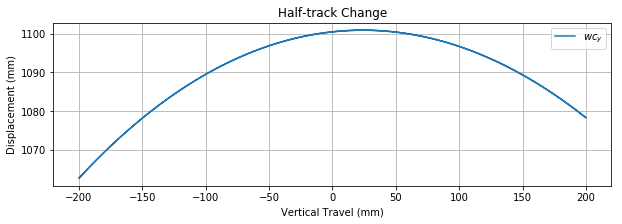

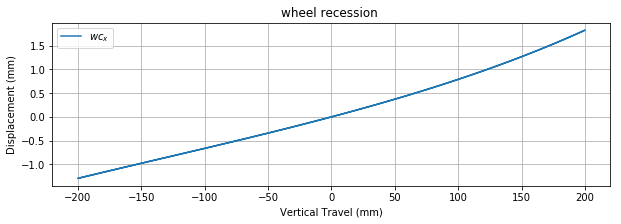

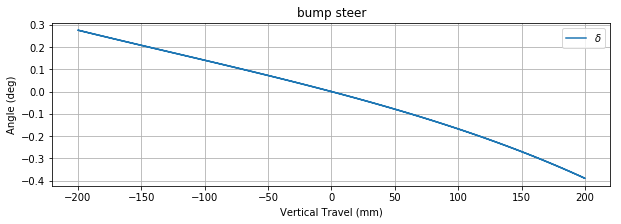

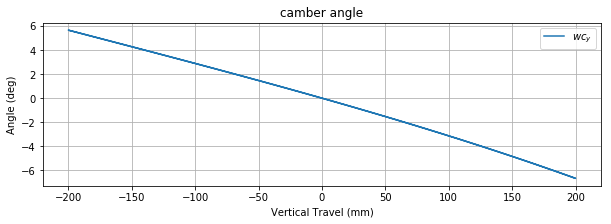

In [22]:
def body_dcm(dataframe,body):
    l=[]
    for i in dataframe.T:
        p=dataframe.loc[i][body+'.e0':body+'.e3']
        dcm=ep2dcm(p)
        l.append(dcm)
    return l


wheel_reference = body_dcm(kds_run[0],'wheel')
y_wheel = [i[:,1] for i in wheel_reference]
z_wheel = [i[:,2] for i in wheel_reference]
z_caster = [i[:,2] for i in wheel_reference]

for i in y_wheel:
    i[2]=0

for i in z_wheel:
    i[0]=0

#for i in z_caster:
#    i[1]=0


steer_angle = []
for i in y_wheel:
    i=i/np.linalg.norm(i)
    if i[0]<=0:
        angle = np.rad2deg(np.arccos(i.dot(np.array([0,1,0]))))
    else:
        angle = np.rad2deg(np.arccos(i.dot(np.array([0,1,0]))))
        angle = angle*-1
    steer_angle.append(angle)     
        
camber_angle = []
for i in z_wheel:
    i=i/np.linalg.norm(i)
    if i[1]<=0:
        angle = -1*np.rad2deg(np.arccos(i.dot(np.array([0,0,1]))))
    else:
        angle = np.rad2deg(np.arccos(i.dot(np.array([0,0,1]))))
    camber_angle.append(angle)     

#caster_angle = []
#for i in z_caster:
#    i=i/np.linalg.norm(i)
#    if i[1]<=0:
#        angle = -1*np.rad2deg(np.arccos(i.dot(np.array([0,0,1]))))
#    else:
#        angle = np.rad2deg(np.arccos(i.dot(np.array([0,0,1]))))
#    caster_angle.append(angle)
#

#camber_angle = []
#for i in z_wheel:
#    if i[1]<=0:
#        angle = vector(i).angle_between(vector([0,0,1]))
#    else:
#        print('5ra')
#        angle = vector(i).angle_between(vector([0,0,1]))
#        angle = angle*-1
#    camber_angle.append(angle)  


figsize=(10,3)
plt.figure('Half-track Change',figsize=figsize)
plt.title('Half-track Change')
plt.plot(vertical_motion,kds_run[0]['wheel.y'][1:],label=r'$wc_{y}$')
plt.legend()
plt.xlabel('Vertical Travel (mm)')
plt.ylabel('Displacement (mm)')
plt.grid()
plt.show()

plt.figure('wheel recession ',figsize=figsize)
plt.title('wheel recession ')
plt.plot(vertical_motion,kds_run[0]['wheel.x'][1:],label=r'$wc_{x}$')
plt.legend()
plt.xlabel('Vertical Travel (mm)')
plt.ylabel('Displacement (mm)')
plt.grid()
plt.show()

plt.figure('bump steer',figsize=figsize)
plt.title('bump steer')
plt.plot(vertical_motion,steer_angle[1:],label=r'$\delta$')
plt.legend()
plt.xlabel('Vertical Travel (mm)')
plt.ylabel('Angle (deg)')
plt.grid()
plt.show()

plt.figure('camber angle',figsize=figsize)
plt.title('camber angle')
plt.plot(vertical_motion,camber_angle[1:],label=r'$wc_{y}$')
plt.legend()
plt.xlabel('Vertical Travel (mm)')
plt.ylabel('Angle (deg)')
plt.grid()
plt.show()


#plt.figure('caster angle',figsize=figsize)
#plt.plot(vertical_motion,caster_angle[1:],label=r'$wc_{y}$')
#plt.legend()
#plt.xlabel('Vertical Travel (mm)')
#plt.ylabel('Angle (deg)')
#plt.grid()
#plt.show()
#
